# Cat Photo Prediction

### Importing the required libraries

In [24]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

### Loading the dataset

In [25]:
def load_data():
    train_dataset = h5py.File('Dataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('Dataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [26]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

**Checking the loaded data with some random index to get sure about the data available**

y = 1. It's a cat picture.


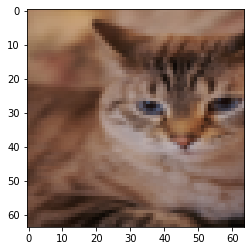

In [27]:
index = 145
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

### Exploring the data and getting the dimensions right

In [28]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [29]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0],-1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


### Getting the constants defining the model

In [30]:
n_x = 12288 
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

### Designing the helper functions

In [31]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

This Function Implements the **sigmoid activation** in numpy

    Arguments:
            Z - numpy array of any shape

    Returns:
            A - output of sigmoid(z), same shape as Z
            cache - returns Z as well, useful during backpropagation
            
Implement the **backward propagation** for a **single SIGMOID unit**.

    Arguments:
            dA - post-activation gradient, of any shape
            cache - 'Z' where we store for computing backward propagation efficiently

    Returns:
            dZ - Gradient of the cost with respect to Z

In [32]:
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

Implement the **RELU function**.

    Arguments:
            Z - Output of the linear layer, of any shape

    Returns:
            A - Post-activation parameter, of the same shape as Z
            cache - a python dictionary containing "A" ; stored for computing the backward pass efficiently
            
Implement the **backward propagation** for a **single RELU unit**.

    Arguments:
            dA - post-activation gradient, of any shape
            cache - 'Z' where we store for computing backward propagation efficiently

    Returns:
            dZ - Gradient of the cost with respect to Z    

In [33]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters     

This function **initializes the parameters** for further use,    
    
    Argument:
        n_x -- size of the input layer
        n_h -- size of the hidden layer
        n_y -- size of the output layer

    Returns:
        parameters - python dictionary containing your parameters:
                W1 - weight matrix of shape (n_h, n_x)
                b1 - bias vector of shape (n_h, 1)
                W2 - weight matrix of shape (n_y, n_h)
                b2 - bias vector of shape (n_y, 1)  

In [34]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

Implement the linear part of a layers **forward propagation**.

    Arguments:
        A - activations from previous layer (or input data): (size of previous layer, number of examples)
        W - weights matrix: numpy array of shape (size of current layer, size of previous layer)
        b - bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
        Z - the input of the activation function, also called pre-activation parameter 
        cache - a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently

Implement the forward propagation for the **LINEAR --- ACTIVATION** layer

    Arguments:
        A_prev - activations from previous layer (or input data): (size of previous layer, number of examples)
        W - weights matrix: numpy array of shape (size of current layer, size of previous layer)
        b - bias vector, numpy array of shape (size of the current layer, 1)
        activation - the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
        A - the output of the activation function, also called the post-activation value 
        cache - a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently

In [35]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

Implement the linear portion of backward propagation for a **single layer**

        Arguments:
            dZ -- Gradient of the cost with respect to the linear output (of current layer l)
            cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

        Returns:
            dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
            dW -- Gradient of the cost with respect to W (current layer l), same shape as W
            db -- Gradient of the cost with respect to b (current layer l), same shape as b
    
Implement the backward propagation for the **LINEAR --- ACTIVATION** layer.
    
        Arguments:
            dA -- post-activation gradient for current layer l 
            cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation 
            activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

        Returns:
            dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
            dW -- Gradient of the cost with respect to W (current layer l), same shape as W
            db -- Gradient of the cost with respect to b (current layer l), same shape as b

In [36]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

Implement the **cost function**.

        Arguments:
            AL - probability vector corresponding to your label predictions, shape (1, number of examples)
            Y - true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

        Returns:
            cost - cross-entropy cost

In [37]:
def update_parameters(parameters, grads, learning_rate):  
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

Update parameters using **gradient descent**
    
    Arguments:
        parameters - python dictionary containing your parameters 
        grads - python dictionary containing your gradients, output of L_model_backward
    
    Returns:
        parameters - python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...

In [38]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

This function is used to predict the results of a  **L-layer neural network**.
    
        Arguments:
            X - data set of examples you would like to label
            parameters - parameters of the trained model

        Returns:
            p - predictions for the given dataset X

In [39]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
   
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 =  linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 =  linear_activation_backward(dA1, cache1, activation='relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Implements a two-layer neural network: **LINEAR -- RELU -- LINEAR -- SIGMOID**.
    
        Arguments:
            X -- input data, of shape (n_x, number of examples)
            Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
            layers_dims -- dimensions of the layers (n_x, n_h, n_y)
            num_iterations -- number of iterations of the optimization loop
            learning_rate -- learning rate of the gradient descent update rule
            print_cost -- If set to True, this will print the cost every 100 iterations 

        Returns:
            parameters -- a dictionary containing W1, W2, b1, and b2

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.17448318112556654
Cost after iteration 1600: 0.17080762978096023


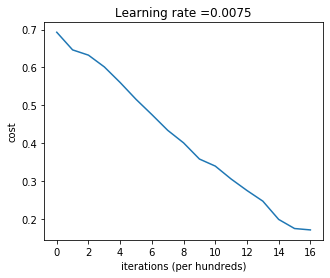

In [40]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 1700, print_cost=True)

In [41]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

Implement forward propagation for the **(LINEAR -- RELU)*(L-1) -- LINEAR -- SIGMOID** computation
    
    Arguments:
        X -- data, numpy array of shape (input size, number of examples)
        parameters -- output of initialize_parameters_deep()
    
    Returns:
        AL -- last post-activation value
        caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)

In [42]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9808612440191385


In [43]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72
